# Example of temporal mapping optimization in a single-PE toy architecture, using INLP => NLP relaxation

## Toy example

* Dense GEMM (IK x KJ with contracted dimension K)
* 2-layer memory hierarchy
* Single-PE, temporal mapping only
* For sake of simplification, this example is "tile-pair stationary", i.e. one pair of tiles (Atile,Btile) is loaded at a time from L*x* to L*x-1*; the only mapping flexibility is in the size and shape of those tiles. The tiles must be equal-sized in the K-dimension. For a given tile pair that is stationary in buffer, pairs of *aik* and *bkj* operands can repeatedly be pulled from buffer into MAC until all partial sums have been calculated for that pair of tiles


## Note:

* For simplicity, this example does not consider how psums are (1) accumulated or (2) moved back to DRAM, i.e. only operand mapping is considered
* "Tile-pair stationary" ignores a **critical** reuse opportunity: the opportunity to move a tile of A from DRAM to Buffer, and then hold it stationary in buffer while different tiles of B are moved from DRAM to Buffer and psums are calculated for each. Or the other way around - hold the B tile stationary, and pull different A tiles down from DRAM.

## Background: toy architecture and optimization of relaxed INLP => NLP problem

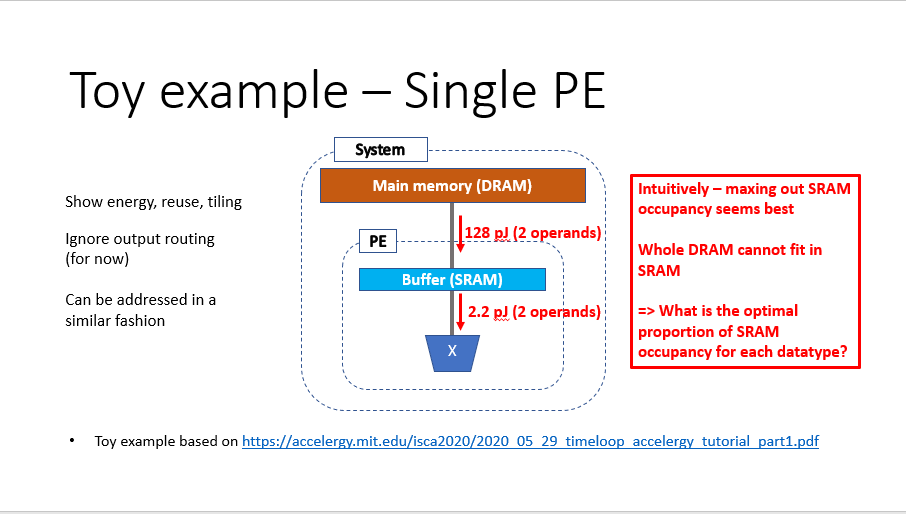

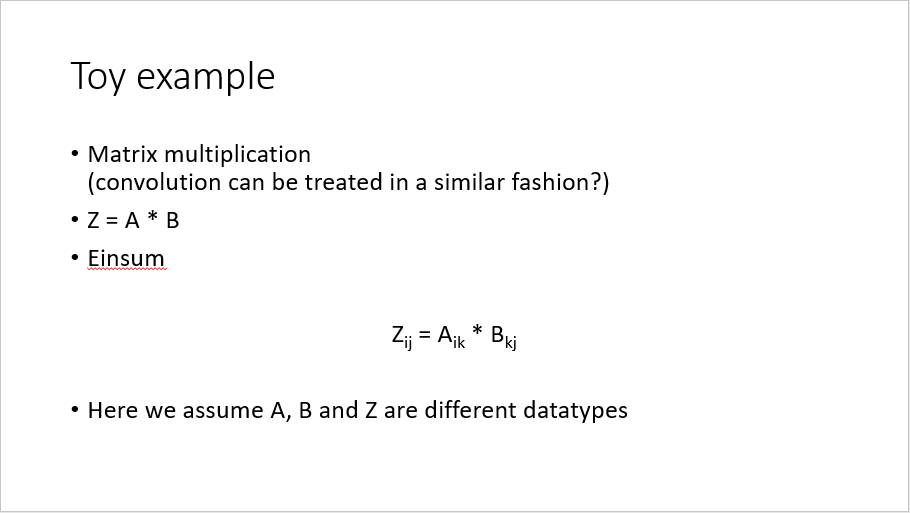

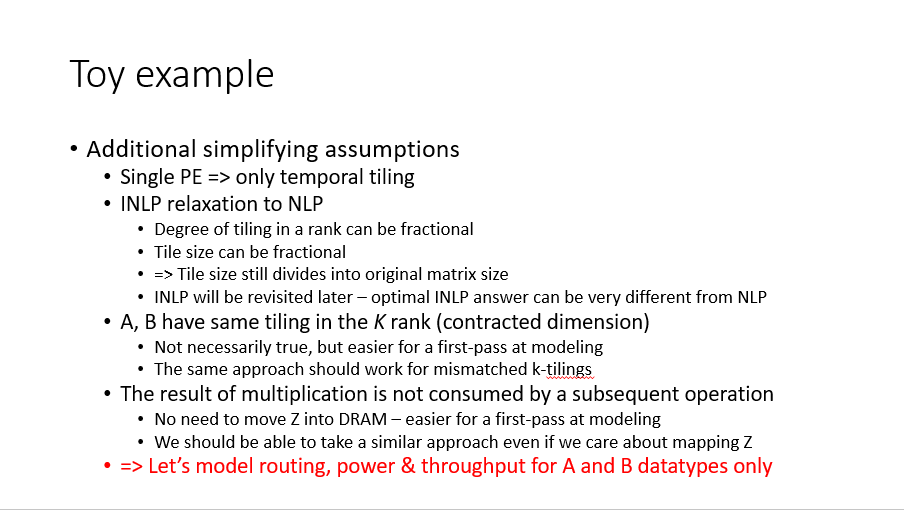

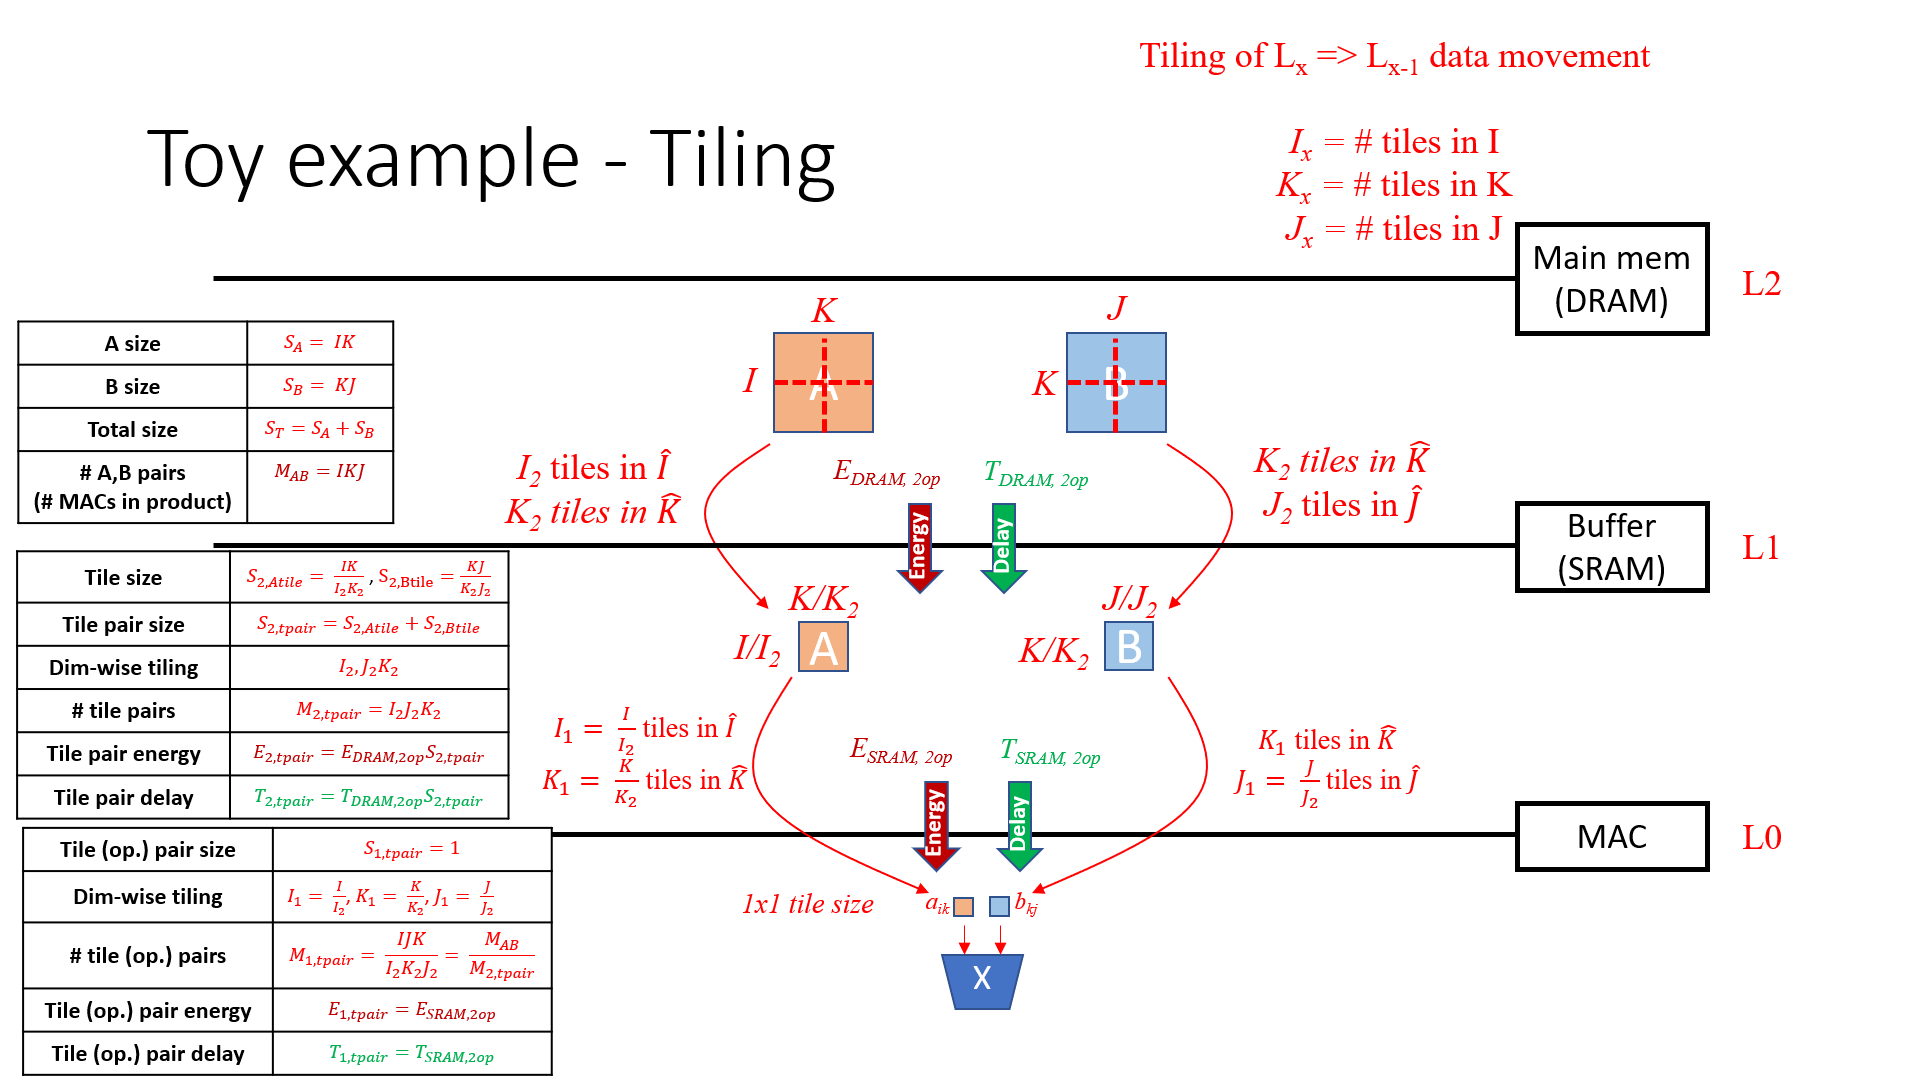

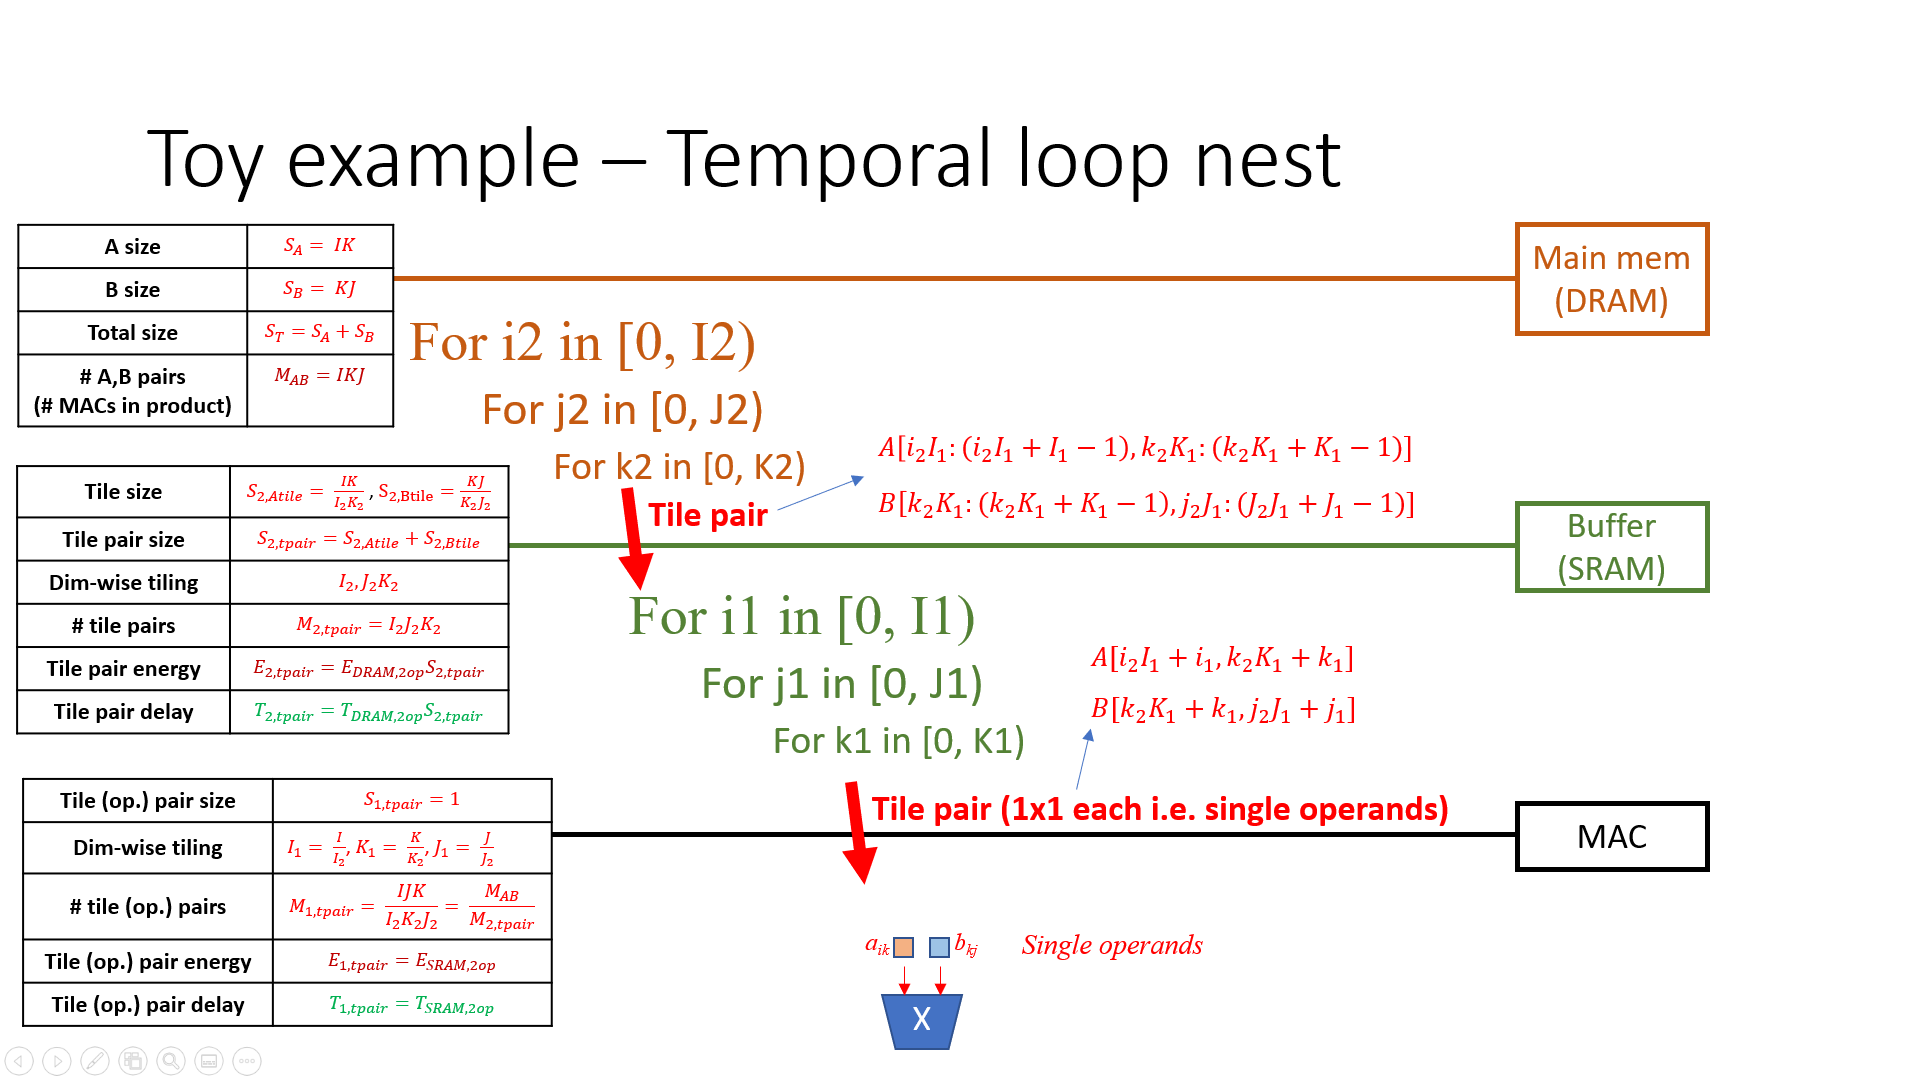

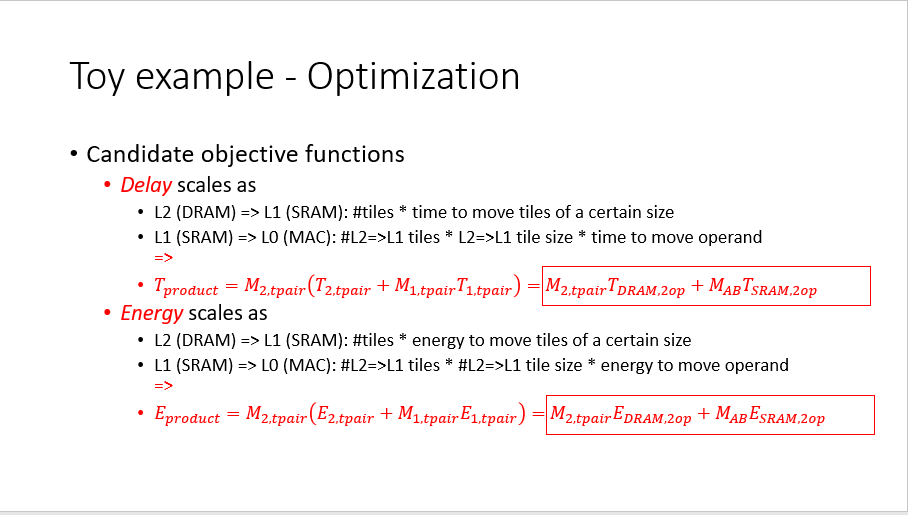

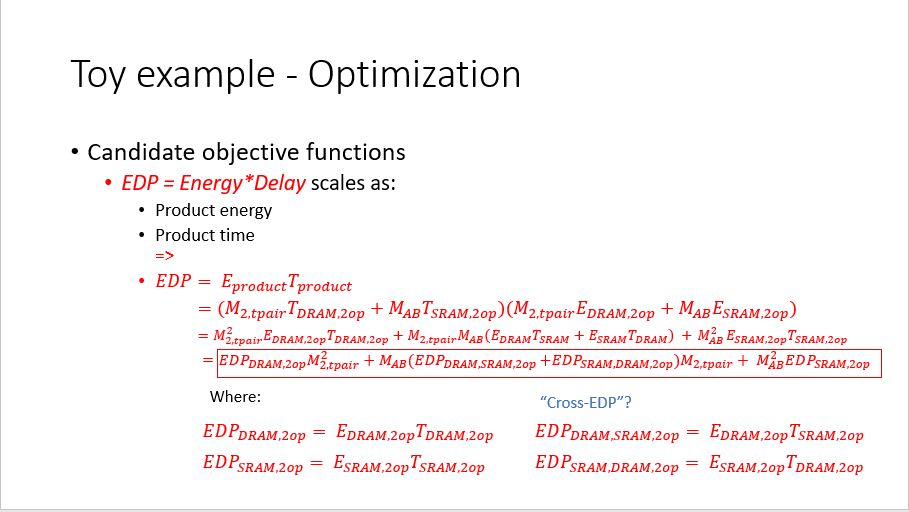

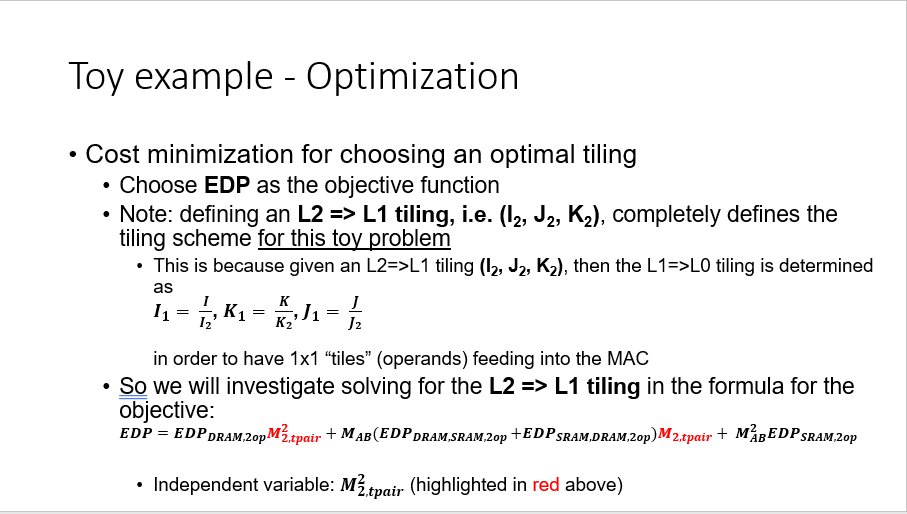

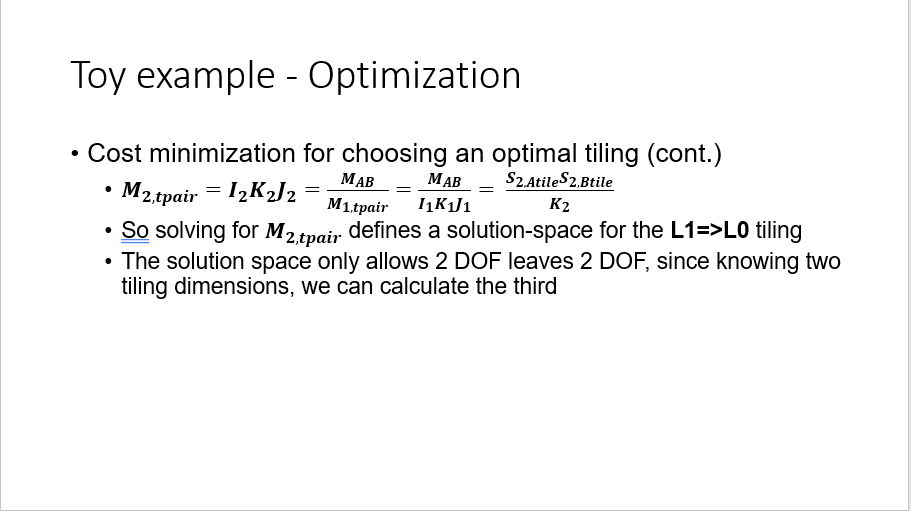

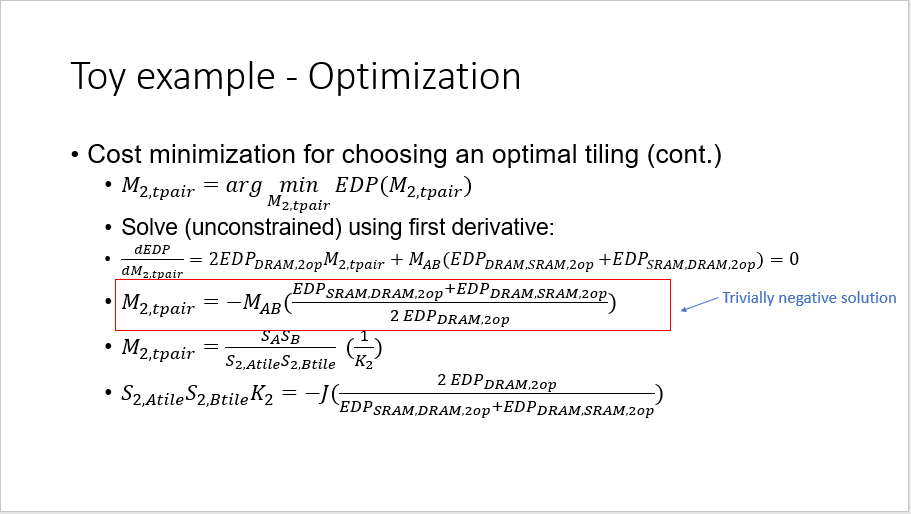

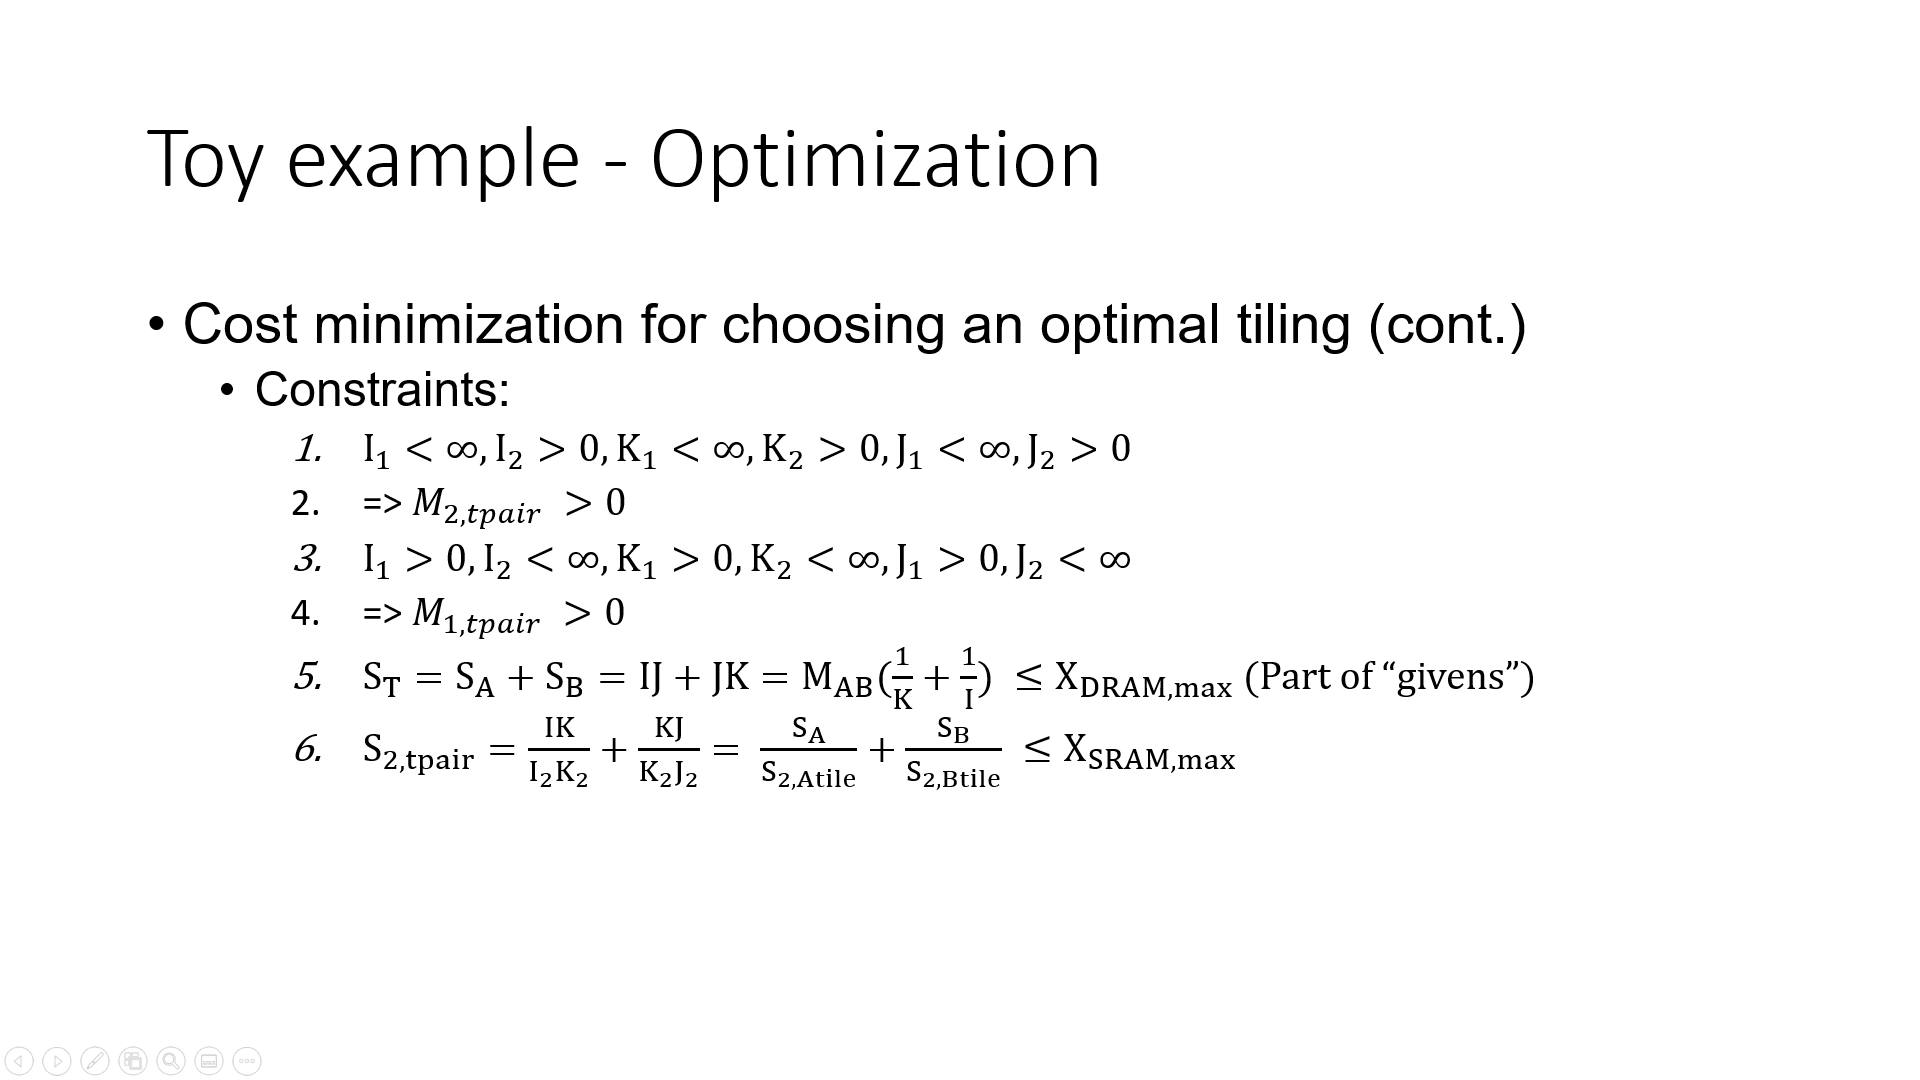

## Now allow separate reuse of the A tile (ik) and B tile (kj) at each level

*vx* - at level x - A is outer loop is 0, B is outer loop if 1
v2, v1

Assume concordant traversal

v1 corresponds to having the MAC hold the a or b operand stationary while the other is varied

In [201]:
from sympy import *

I,J,K,I2,J2,K2,EDRAM1op,TDRAM1op,MAB,ESRAM1op,TSRAM1op,XSRAMmax,v2,v1=symbols("I,J,K,I2,J2,K2,EDRAM1op,TDRAM1op,MAB,ESRAM1op,TSRAM1op,XSRAMmax,v2,v1")

# M_{AB} = 125 element pair (MACS) between two 5x5 matrices A and B
# E_{DRAM2op} = 128pJ to move 2 8-bit operands from DRAM Main Memory to SRAM
# E_{SRAM2op} = 2.2pJ to move 2 8-bit operands from SRAM Buffer to MAC
# T_{DRAM2op} = 100ps to move 2 8-bit operands from DRAM Main Memory to SRAM
# T_{SRAM2op} = 1ps to move 2 8-bit operands from DRAM Main Memory to SRAM
scenario_values={EDRAM1op:64,TSRAM1op:0.5,ESRAM1op:1,TDRAM1op:50,XSRAMmax:80,I:5,J:5,K:5}

### L2 => L1

Treat the v2 = 0, v2 = 1 as routing templates which may be superimposed with weightings r20, r21=1-r20 - in line with the approach of relaxing integer constraints.

#### Atile-stationary (v2=0):

* #tile pairs: *M2tilepair*
* #B tiles per A tile: J2/I2
* Amortize the cost of each A-tile movement over each B-tile movements



In [202]:
# L2 objective function, A-tile-stationary/v2=0

S2Atile = I*K/(I2*K2)
S2Btile = K*J/(K2*J2)

# for k in K2
#  for i in I2
#   Load ith A-tile and hold stationary
#   for j in J2
#    Load jth B-tile
#    (we can model A-tile costs as being amortized over these B-tile loads)

# - Energy per A/B tile pair, assuming A tile is loaded once and held stationary, and that time/energy costs of that load
#   are amortized over B-tile loads *in the inner-loop*
BperAstat=J2/I2
Delay2TileA=TDRAM1op*S2Atile
Delay2TileB=TDRAM1op*S2Btile
Delay2TileB_AmortStatA=Delay2TileA/BperAstat + Delay2TileB 
Energy2TileA=EDRAM1op*S2Atile
Energy2TileB=EDRAM1op*S2Btile
Energy2TileB_AmortStatA=Energy2TileA/BperAstat + Energy2TileB 

# - Energy of all A,B tile pair loads
Delay2Total_StatA=Delay2TileB_AmortStatA*I2*J2*K2
Energy2Total_StatA=Energy2TileB_AmortStatA*I2*J2*K2
expand(Delay2Total_StatA)

I*I2*K*TDRAM1op + I2*J*K*TDRAM1op

In [203]:
# L2 objective function, B-tile-stationary/v2=1

S2Atile = I*K/(I2*K2)
S2Btile = K*J/(K2*J2)

# for k in K2
#  for j in J2
#   Load jth B-tile and hold stationary
#   for i in I2
#    Load ith A-tile
#    (we can model B-tile costs as being amortized over these A-tile loads)

# - Energy per A/B tile pair, assuming B tile is loaded once and held stationary, and that time/energy costs of that load
#   are amortized over A-tile loads *in the inner-loop*
AperBstat=I2/J2
Delay2TileA=TDRAM1op*S2Atile
Delay2TileB=TDRAM1op*S2Btile
Delay2TileA_AmortStatB=Delay2TileA + Delay2TileB/AperBstat
Energy2TileA=EDRAM1op*S2Atile
Energy2TileB=EDRAM1op*S2Btile
Energy2TileA_AmortStatB=Energy2TileA + Energy2TileB/AperBstat

# - Energy of all A,B tile pair loads
Delay2Total_StatB=Delay2TileA_AmortStatB*I2*J2*K2
Energy2Total_StatB=Energy2TileA_AmortStatB*I2*J2*K2
expand(Delay2Total_StatB)

I*J2*K*TDRAM1op + J*J2*K*TDRAM1op

In [204]:
# L1 objective function, A-tile-stationary/v1=0

I1 = I/I2
K1 = K/K2
J1 = J/J2

S1Atile = 1
S1Btile = 1

# for k in K1
#  for i in I1
#   Load ith A-tile and hold stationary
#   for j in J1
#    Load jth B-tile
#    (we can model A-tile costs as being amortized over these B-tile loads)

# - Energy per A/B tile pair, assuming A tile is loaded once and held stationary, and that time/energy costs of that load
#   are amortized over B-tile loads *in the inner-loop*
BperAstat=J1/I1
Delay1TileA=TSRAM1op*S1Atile
Delay1TileB=TSRAM1op*S1Btile
Delay1TileB_AmortStatA=Delay1TileA/BperAstat + Delay1TileB 
Energy1TileA=ESRAM1op*S1Atile
Energy1TileB=ESRAM1op*S1Btile
Energy1TileB_AmortStatA=Energy1TileA/BperAstat + Energy1TileB 

# - Energy of all A,B tile pair loads
Delay1Total_StatA=Delay1TileB_AmortStatA*I1*J1*K1*I2*J2*K2
Energy1Total_StatA=Energy1TileB_AmortStatA*I1*J1*K1*I2*J2*K2
expand(simplify(Delay1Total_StatA))

I**2*J2*K*TSRAM1op/I2 + I*J*K*TSRAM1op

In [205]:
# L1 objective function, B-tile-stationary/v1=1

I1 = I/I2
K1 = K/K2
J1 = J/J2

S1Atile = 1
S1Btile = 1

# for k in K1
#  for j in J1
#   Load ith B-tile and hold stationary
#   for i in I1
#    Load ith A-tile
#    (we can model B-tile costs as being amortized over these A-tile loads)

# - Energy per A/B tile pair, assuming B tile is loaded once and held stationary, and that time/energy costs of that load
#   are amortized over A-tile loads *in the inner-loop*
AperBstat=I1/J1
Delay1TileA=TSRAM1op*S1Atile
Delay1TileB=TSRAM1op*S1Btile
Delay1TileA_AmortStatB=Delay1TileA + Delay1TileB/AperBstat
Energy1TileA=ESRAM1op*S1Atile
Energy1TileB=ESRAM1op*S1Btile
Energy1TileA_AmortStatB=Energy1TileA + Energy1TileB/AperBstat

# - Energy of all A,B tile pair loads
Delay1Total_StatB=Delay1TileA_AmortStatB*I1*J1*K1*I2*J2*K2
Energy1Total_StatB=Energy1TileA_AmortStatB*I1*J1*K1*I2*J2*K2
expand(simplify(Delay1Total_StatB))

I*J*K*TSRAM1op + I2*J**2*K*TSRAM1op/J2

In [206]:
EDP_v2_0_v1_0 = (Energy2Total_StatA+Energy1Total_StatA)*(Delay2Total_StatA + Delay1Total_StatA)
EDP_v2_0_v1_1 = (Energy2Total_StatA+Energy1Total_StatB)*(Delay2Total_StatA + Delay1Total_StatB) 
EDP_v2_1_v1_0 = (Energy2Total_StatB+Energy1Total_StatA)*(Delay2Total_StatB + Delay1Total_StatA) 
EDP_v2_1_v1_1 = (Energy2Total_StatB+Energy1Total_StatB)*(Delay2Total_StatB + Delay1Total_StatB) 

EDP = (1-v2)*(1-v1)*EDP_v2_0_v1_0 + (1-v2)*v1*EDP_v2_0_v1_1 + v2*(1-v1)*EDP_v2_1_v1_0 + v2*v1*EDP_v2_1_v1_1

EDP=cancel(expand(simplify(EDP)))
EDP

(EDRAM1op*I**3*I2**2*J2**3*K**2*TSRAM1op*v1*v2 - EDRAM1op*I**3*I2**2*J2**3*K**2*TSRAM1op*v1 - EDRAM1op*I**3*I2**2*J2**3*K**2*TSRAM1op*v2 + EDRAM1op*I**3*I2**2*J2**3*K**2*TSRAM1op - EDRAM1op*I**3*I2*J2**4*K**2*TSRAM1op*v1*v2 + EDRAM1op*I**3*I2*J2**4*K**2*TSRAM1op*v2 - EDRAM1op*I**2*I2**4*J2**2*K**2*TDRAM1op*v2 + EDRAM1op*I**2*I2**4*J2**2*K**2*TDRAM1op - EDRAM1op*I**2*I2**3*J*J2**2*K**2*TSRAM1op*v2 + EDRAM1op*I**2*I2**3*J*J2**2*K**2*TSRAM1op + EDRAM1op*I**2*I2**2*J*J2**3*K**2*TSRAM1op*v1*v2 - EDRAM1op*I**2*I2**2*J*J2**3*K**2*TSRAM1op*v1 + EDRAM1op*I**2*I2**2*J*J2**3*K**2*TSRAM1op + EDRAM1op*I**2*I2**2*J2**4*K**2*TDRAM1op*v2 - EDRAM1op*I**2*I2*J*J2**4*K**2*TSRAM1op*v1*v2 + EDRAM1op*I**2*I2*J*J2**4*K**2*TSRAM1op*v2 - EDRAM1op*I*I2**4*J**2*J2*K**2*TSRAM1op*v1*v2 + EDRAM1op*I*I2**4*J**2*J2*K**2*TSRAM1op*v1 - 2*EDRAM1op*I*I2**4*J*J2**2*K**2*TDRAM1op*v2 + 2*EDRAM1op*I*I2**4*J*J2**2*K**2*TDRAM1op + EDRAM1op*I*I2**3*J**2*J2**2*K**2*TSRAM1op*v1*v2 - EDRAM1op*I*I2**3*J**2*J2**2*K**2*TSRAM1op*v2 + 

In [207]:
from sympy.solvers.solveset import nonlinsolve

EDP_I2 = factor(simplify(EDP.diff(I2)))
EDP_K2 = factor(simplify(EDP.diff(K2)))
EDP_J2 = factor(simplify(EDP.diff(J2)))
EDP_v1 = factor(simplify(EDP.diff(v1)))
EDP_v2 = factor(simplify(EDP.diff(v2)))

EDP_I2



K**2*(EDRAM1op*I**3*I2*J2**4*TSRAM1op*v1*v2 - EDRAM1op*I**3*I2*J2**4*TSRAM1op*v2 - 2*EDRAM1op*I**2*I2**4*J2**2*TDRAM1op*v2 + 2*EDRAM1op*I**2*I2**4*J2**2*TDRAM1op - EDRAM1op*I**2*I2**3*J*J2**2*TSRAM1op*v2 + EDRAM1op*I**2*I2**3*J*J2**2*TSRAM1op + EDRAM1op*I**2*I2*J*J2**4*TSRAM1op*v1*v2 - EDRAM1op*I**2*I2*J*J2**4*TSRAM1op*v2 - 2*EDRAM1op*I*I2**4*J**2*J2*TSRAM1op*v1*v2 + 2*EDRAM1op*I*I2**4*J**2*J2*TSRAM1op*v1 - 4*EDRAM1op*I*I2**4*J*J2**2*TDRAM1op*v2 + 4*EDRAM1op*I*I2**4*J*J2**2*TDRAM1op + EDRAM1op*I*I2**3*J**2*J2**2*TSRAM1op*v1*v2 - EDRAM1op*I*I2**3*J**2*J2**2*TSRAM1op*v2 + EDRAM1op*I*I2**3*J**2*J2**2*TSRAM1op - 2*EDRAM1op*I2**4*J**3*J2*TSRAM1op*v1*v2 + 2*EDRAM1op*I2**4*J**3*J2*TSRAM1op*v1 - 2*EDRAM1op*I2**4*J**2*J2**2*TDRAM1op*v2 + 2*EDRAM1op*I2**4*J**2*J2**2*TDRAM1op + EDRAM1op*I2**3*J**3*J2**2*TSRAM1op*v1*v2 + 2*ESRAM1op*I**4*J2**4*TSRAM1op*v1 - 2*ESRAM1op*I**4*J2**4*TSRAM1op + 2*ESRAM1op*I**3*I2*J*J2**3*TSRAM1op*v1 - 2*ESRAM1op*I**3*I2*J*J2**3*TSRAM1op + ESRAM1op*I**3*I2*J2**4*TDRAM1op

# Hand-made Branch and Bound (BnB) implementation

In [208]:
EDP_num = EDP.subs(scenario_values)
EDP_num

(-8000000*I2**4*J2**2*v2 + 8000000*I2**4*J2**2 - 512500.0*I2**4*J2*v1*v2 + 512500.0*I2**4*J2*v1 + 7812.5*I2**4*v1 + 512500.0*I2**3*J2**2*v1*v2 - 512500.0*I2**3*J2**2*v2 + 512500.0*I2**3*J2**2 + 15625.0*I2**3*J2*v1 + 8000000*I2**2*J2**4*v2 + 512500.0*I2**2*J2**3*v1*v2 - 512500.0*I2**2*J2**3*v1 + 512500.0*I2**2*J2**3 + 7812.5*I2**2*J2**2 - 512500.0*I2*J2**4*v1*v2 + 512500.0*I2*J2**4*v2 - 15625.0*I2*J2**3*v1 + 15625.0*I2*J2**3 - 7812.5*J2**4*v1 + 7812.5*J2**4)/(I2**2*J2**2)

In [209]:
f = lambda _x: float(EDP_num.subs({"I2":_x[0],"K2":_x[1],"J2":_x[2],"v1":_x[3],"v2":_x[4]}).evalf())

In [213]:
from sympy.utilities.lambdify import lambdify
import numpy as np

# Hypothetical EDP function, 5 variables
# _x[0] = I2
# _x[1] = K2
# _x[2] = J2
# _x[3] = v1
# _x[4] = v2
f = lambda _x: float(EDP_num.subs({"I2":_x[0],"K2":_x[1],"J2":_x[2],"v1":_x[3],"v2":_x[4]}).evalf())
 
# Hypothetical variables defining the problem space
#I = 10
#K = 2
#J = 5
#L1max = 20

I = scenario_values[I]
K = scenario_values[K]
J = scenario_values[J]
XSRAMmax=scenario_values[XSRAMmax]

# Bounds within the whole problem instance
bounds=[(1,I),(1,K),(1,J),(0,1),(0,1)]

# Relaxed problem constraints
# The unrelaxed problem has an integer constraint
cL1 = {"type":"ineq","fun":lambda _x: XSRAMmax - I*K/_x[0]/_x[1] + K*J/_x[1]/_x[2]}
constraints=[cL1]

## INLP relaxation

In [214]:
from random import random

# Rectify the global minimum solution of the NLP bound() function
def unrelax(_x, _bounds):
    return np.array([min(max(_bd[0],round(_xk)),_bd[1]) for _xk,_bd in zip(_x,_bounds)])

## Branch and bound functions

In [215]:
# Optimization library
from scipy.optimize import shgo
from functools import total_ordering
import heapq

# bound() function and solution() function rolled into one
## Example: bounds=[(1,I),(1,J),(1,K),(0,1),(0,1)]
## Consider: n, iters, callback, options
relaxed_ilp = lambda _bounds: shgo(func=f,bounds=_bounds,constraints=constraints,sampling_method="simplicial")

# Returns (bound,solution)
def bound_solution(_rilp, _f, _instance):
    ilp_result = _rilp(_instance)
    bound = ilp_result.fun
    guess_relaxed = ilp_result.x
    guess = unrelax(guess_relaxed,_instance)    
    best = _f(guess)
    return (bound,best,guess,guess_relaxed)

# Returns a list of instances that both exclude _x
def branch(_x, _instance):
    _branches=[]
    
    # 'Up branch'
    _branches = _branches + [[(min(_xk+1,_bd[1]),_bd[1]) for _xk,_bd in zip(_x,_instance)]]
    
    # 'Down branch'
    _branches = _branches + [[(_bd[0],max(_bd[0],_xk-1)) for _xk,_bd in zip(_x,_instance)]]    
    
    # 'Singleton branches'
    for v1 in _instance[3]:
        for v2 in _instance[4]:
            if not(v1 == _x[3] and v2 == _x[4]):
                x2 = _x.copy()
                x2[3] = v1
                x2[4] = v2
                _branches = _branches +[[(xk,xk) for xk in x2]]
    
    return _branches
                                                             
def is_singleton(_instance):
    sing = all([_bds[0] == _bds[1] for _bds in _instance])
    empt = any([_bds[1] < _bds[0] for _bds in _instance])
    
    if empt:
        return 0
    elif sing:
        return 1
    else:
        return 2

def breakout_singleton(_instance):
    return np.array([_bd[0] for _bd in _instance])

# Representation of (bound,instance) pair that can be sorted by a heapq (priority queue)
# From https://stackoverflow.com/questions/42985030/inserting-dictionary-to-heap-python
@total_ordering
class Instance(object):
    def __init__(self, _instance, _bound, _best, _guess):
        self.instance = _instance
        self.bound = _bound
        self.best = _best
        self.guess = _guess        

    def __lt__(self, other):
        return self.bound < other.bound
    
    def __gt__(self, other):
        return self.bound > other.bound    

    def __eq__(self, other):
        return self.bound == other.bound
    
    def breakout(self):
        return (self._instance,self._bound,self._best,self._guess)

    def __repr__(self):
        return '{0.__class__.__name__}(bound={0.bound}, instance={0.instance})'.format(self)
    
# "Best-first" implementation from https://en.wikipedia.org/wiki/Branch_and_bound
# Returns (best, guess)
def bnb(instance, _rilp, _f):
    # Print instance details
    print("Initial instance: " + str(instance))
    
    # Initial guess based on heuristic
    (bound,best,guess,guess_relaxed) = bound_solution(_rilp, _f, instance)
    
    if is_singleton(instance) == 1:
        print("\n\nBest guess: bound=" + str(bound) + " guess_relaxed=" + str(guess_relaxed) +  " best=" + str(best) + " guess=" + str(guess))   
        return (best, guess)
    
    print("Initial guess: bound=" + str(bound) + " guess_relaxed=" + str(guess_relaxed) + " best=" + str(best) + " guess=" + str(guess))    
    
    # Initialize "best queue"
    bestq = []

    # Initial branch
    branches = branch(guess,instance)
    
    for _instance in branches:
        _guess_relaxed = breakout_singleton(_instance)        
        
        if is_singleton(_instance) == 0:
            
            print("Discarding candidate empty branch: instance=" + str(_instance)) 
            
        if is_singleton(_instance) == 1:            
            
            print("Candidate singleton branch: instance=" + str(_instance)) 
            _guess = unrelax(_guess_relaxed,_instance)
            _bound = _f(_guess_relaxed) 
            _best = _f(_guess) 
            
            print("Candidate singleton branch guess: bound=" + str(_bound) + " best=" + str(_best) + " guess=" + str(_guess)) 
            if _best < best:
                # Singleton branch beats the best solution we've found so far
                instance = _instance
                bound = _bound
                best = _best
                guess = _guess
                print("Update best; discard candidate singleton branch.")
            else:
                print("Discard singleton branch.")
            
        else:
            print("Candidate non-singleton branch: instance=" + str(_instance)) 
            
            # Find a solution guess that lower-/upper-bounds each branch
            # push branch if LB beats the current best UB
            (_bound,_best,_guess,_guess_relaxed) = bound_solution(_rilp, _f, _instance)
            print("Candidate non-singleton branch guess: bound=" + str(_bound) + " guess_relaxed=" + str(_guess_relaxed) + " best=" + str(_best) + " guess=" + str(_guess))        
            if _bound <= best:
                print("Pushing candidate non-singleton branch.")
                heapq.heappush(bestq,Instance(_instance,_bound,_best,_guess))
            else:
                print("Discarding candidate non-singleton branch.")
    
    print("Queue length: "  + str(len(bestq)))
    
    while len(bestq)>0:
        print("------------------- Visiting instance (queue length: " + stir(len(bestq)) + ") --------------------")        
        
        # Pop a branch
        _instance, _bound, _best, _guess = heapq.heappop(bestq).breakout()
        print("Visiting instance: " + str(instance) + " bound=" + str(bound) + " best=" + str(best) + " guess=" + str(guess))
        
        # Branch
        branches = branch(_guess,_instance)       
        for _instance in branches:
            _guess_relaxed = breakout_singleton(_instance)        

            if is_singleton(_instance):
                print("Singleton branch: instance=" + str(_instance)) 
                _guess = unrelax(_guess_relaxed,_instance)
                _bound = _f(_guess_relaxed) 
                _best = _f(_guess) 

                print("Singleton branch guess: bound=" + str(_bound) + " best=" + str(_best) + " guess=" + str(_guess)) 
                if _best < best:
                    # Singleton branch beats the best solution we've found so far
                    instance = _instance
                    bound = _bound
                    best = _best
                    guess = _guess
                    print("Update best; discard singleton branch.")
                else:
                    print("Discard singleton branch.")

            else:
                print("Non-singleton branch: instance=" + str(_instance)) 

                # Find a solution guess that lower-/upper-bounds each branch
                # push branch if LB beats the current best UB
                (_bound,_best,_guess,_guess_relaxed) = bound_solution(_rilp, _f, _instance)
                print("Non-singleton branch guess: bound=" + str(_bound) + " guess_relaxed=" + str(_guess_relaxed) + " best=" + str(_best) + " guess=" + str(_guess))        
                if _bound <= best:
                    print("Pushing branch.")
                    heapq.heappush(bestq,Instance(_instance,_bound,_best,_guess))
                else:
                    print("Discarding branch.")

        print("------------------- Leaving instance --------------------")
        
    print("\n\nBest guess: bound=" + str(bound) + " best=" + str(best) + " guess=" + str(guess))   
        
    return (best, guess)

## Branch and bound result

In [216]:
res=bnb(bounds, relaxed_ilp, f)

Initial instance: [(1, 5), (1, 5), (1, 5), (0, 1), (0, 1)]
Initial guess: bound=8626250.0 guess_relaxed=[5. 5. 1. 0. 1.] best=8626250.0 guess=[5 5 1 0 1]
Candidate non-singleton branch: instance=[(5, 5), (5, 5), (2, 5), (1, 1), (1, 1)]
Candidate non-singleton branch guess: bound=35683203.125 guess_relaxed=[5. 5. 2. 1. 1.] best=35683203.125 guess=[5 5 2 1 1]
Discarding candidate non-singleton branch.
Candidate non-singleton branch: instance=[(1, 4), (1, 4), (1, 1), (0, 0), (0, 0)]
Candidate non-singleton branch guess: bound=9056250.0 guess_relaxed=[1. 1. 1. 0. 0.] best=9056250.0 guess=[1 1 1 0 0]
Discarding candidate non-singleton branch.
Candidate singleton branch: instance=[(5, 5), (5, 5), (1, 1), (0, 0), (0, 0)]
Candidate singleton branch guess: bound=203086250.0 best=203086250.0 guess=[5 5 1 0 0]
Discard singleton branch.
Candidate singleton branch: instance=[(5, 5), (5, 5), (1, 1), (1, 1), (0, 0)]
Candidate singleton branch guess: bound=215656250.0 best=215656250.0 guess=[5 5 1 1 0

In [218]:
print(cL1["fun"](res[1]))

84.0

## Observations

Branch scheme used above does not effectively enforce memory level size bound

# Python Branch-and-Bound library (pyBnB)